In [12]:
import numpy as np
import jax.numpy as jnp
from jax import jacfwd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from controller_Nash import PCEController
from scipy.linalg import solve_continuous_lyapunov as solve_lyapunov
from numpy.linalg import norm, inv
from scipy.integrate import solve_ivp

In [13]:
# システム行列の例
def A_delta(delta):
    return np.array([
    [-2, 1.0],
    [0.0, -3.0 + delta]
])

def B1_delta(delta):
    return np.array([
    [1.0],
    [0.1]
])

def B2_delta(delta):
    return np.array([
    [0.1],
    [1.0]
])

Q1 = np.array([[1, 0.0], [0.0, 0.1]])
Q2 = np.array([[0.1, 0.0], [0.0, 1]])
R11 = np.array([[1]])
R12 = np.array([[0]])
R21 = np.array([[0]])
R22 = np.array([[1]])
p_order = 3

In [14]:
# インスタンス生成（関数の参照を渡す！）
controller = PCEController(A_delta, B1_delta, B2_delta, Q1, Q2, R11, R12, R21, R22, p_order)

# gPC行列の計算
Agpc = controller.Agpc
B1gpc = controller.B1gpc
B2gpc = controller.B2gpc
Q1= controller.Q1_bar
Q2= controller.Q2_bar
R11= controller.R11_bar
R12= controller.R12_bar
R21= controller.R21_bar
R22= controller.R22_bar
p_terms = controller.p_terms
n = controller.n
# print("Agpc:")
# print(Agpc)
print("B1gpc:")
print(B1gpc)
print("B2gpc:")
print(B2gpc)

B1gpc:
[[ 1.00000000e+00  3.95299921e-18  4.48779225e-17  1.49087720e-18]
 [ 3.95299921e-18  1.00000000e+00 -2.11633968e-17  1.58809783e-16]
 [ 4.48779225e-17 -2.11633968e-17  1.00000000e+00 -1.16477517e-16]
 [ 1.49087720e-18  1.58809783e-16 -1.16477517e-16  1.00000000e+00]
 [ 1.00000000e-01  1.59368146e-19  1.41774036e-18  5.06304598e-19]
 [ 1.59368146e-19  1.00000000e-01 -1.75646743e-18  1.19337687e-17]
 [ 1.41774036e-18 -1.75646743e-18  1.00000000e-01 -1.14748034e-17]
 [ 5.06304598e-19  1.19337687e-17 -1.14748034e-17  1.00000000e-01]]
B2gpc:
[[ 1.00000000e-01  7.06674838e-18  3.70676490e-18  2.08507951e-18]
 [ 7.06674838e-18  1.00000000e-01  9.37418369e-18  1.48768003e-17]
 [ 3.70676490e-18  9.37418369e-18  1.00000000e-01 -4.88852729e-19]
 [ 2.08507951e-18  1.48768003e-17 -4.88852729e-19  1.00000000e-01]
 [ 1.00000000e+00  8.90907322e-17  4.67164481e-17 -5.26567977e-19]
 [ 8.90907322e-17  1.00000000e+00  7.73704814e-17  1.61173602e-16]
 [ 4.67164481e-17  7.73704814e-17  1.00000000e+

In [15]:
"""
ニュートン法で連続時間型リカッチ方程式を解く
A, B, Q, R: numpy配列
tol: 収束許容誤差
max_iter: 最大反復回数
"""
P1, P2 = controller.solve_riccati_newton(Agpc, B1gpc, B2gpc, Q1, Q2, R11, R12, R21, R22)
print("解 P1:")
print(P1)
print("解 P2:")
print(P2)

収束しました。反復回数: 5
解 P1:
[[ 2.35453514e-01 -3.39871464e-05 -1.72535297e-06 -6.07394740e-09
   4.28223001e-02  2.40488447e-03  1.38784530e-04  5.43700782e-06]
 [-3.39871464e-05  2.35451443e-01 -4.07923850e-05 -2.21831096e-06
   2.40488447e-03  4.29888415e-02  2.89285180e-03  1.78437253e-04]
 [-1.72535297e-06 -4.07923850e-05  2.35450504e-01 -4.37010652e-05
   1.38784530e-04  2.89285180e-03  4.30643705e-02  3.09495323e-03]
 [-6.07394740e-09 -2.21831096e-06 -4.37010652e-05  2.35452575e-01
   5.43700782e-06  1.78437253e-04  3.09495323e-03  4.28978291e-02]
 [ 4.28223001e-02  2.40488447e-03  1.38784530e-04  5.43700782e-06
   2.91334198e-02  3.64055136e-03  4.55856781e-04  5.32479883e-05]
 [ 2.40488447e-03  4.29888415e-02  2.89285180e-03  1.78437253e-04
   3.64055136e-03  2.96804479e-02  4.43712333e-03  5.86101576e-04]
 [ 1.38784530e-04  2.89285180e-03  4.30643705e-02  3.09495323e-03
   4.55856781e-04  4.43712333e-03  2.99285332e-02  4.70968739e-03]
 [ 5.43700782e-06  1.78437253e-04  3.09495323e-0

In [ ]:
# 3. フィードバックゲイン計算
K1 = inv(R11) @ B1gpc.T @ P1
K2 = inv(R22) @ B2gpc.T @ P2
A_cl = Agpc - B1gpc @ K1 - B2gpc @ K2  # 閉ループ系
eigvals = np.linalg.eigvals(A_cl)
print("A_cl の固有値:", eigvals)

print("K1:")
print(K1)
print("K2:")
print(K2)

A_cl の固有値: [-3.75769425 -3.3568528  -2.91503012 -2.42223072 -2.39167009 -2.28117621
 -2.26478542 -2.25803457]
K1:
[[2.39735744e-01 2.06501300e-04 1.21531000e-05 5.37626835e-07
  4.57356421e-02 2.76893960e-03 1.84370208e-04 1.07618067e-05]
 [2.06501300e-04 2.39750328e-01 2.48492795e-04 1.56254143e-05
  2.76893960e-03 4.59568863e-02 3.33656413e-03 2.37047410e-04]
 [1.21531000e-05 2.48492795e-04 2.39756942e-01 2.65794258e-04
  1.84370208e-04 3.33656413e-03 4.60572239e-02 3.56592197e-03]
 [5.37626835e-07 1.56254143e-05 2.65794258e-04 2.39742358e-01
  1.07618067e-05 2.37047410e-04 3.56592197e-03 4.58359796e-02]]
K2:
[[ 5.36611331e-03  8.41616025e-05 -7.04093185e-06 -2.14290691e-06
   1.65086132e-01  1.76057179e-02  2.19058580e-03  2.79243375e-04]
 [ 8.41616025e-05  5.35766419e-03  9.82387570e-05 -9.05262667e-06
   1.76057179e-02  1.67714835e-01  2.14858887e-02  2.81646745e-03]
 [-7.04093185e-06  9.82387570e-05  5.35383239e-03  1.07041567e-04
   2.19058580e-03  2.14858887e-02  1.68906990e-01

In [17]:
# 4. シミュレーション
def dynamics(t, x):
    return A_cl @ x

# 初期状態 x(0)
x0 = np.ones([p_terms*n]) # p_terms*nと同じ次元
x0 = 0.00*x0
initial_list = [-5, 6]
for i in range(n):
    x0[i*(p_terms)] = initial_list[i]
t_span = (0, 2)
t_eval = np.linspace(*t_span, 300)

sol = solve_ivp(dynamics, t_span, x0, t_eval=t_eval)

# 5. ノルムの時間変化を計算
x_t = sol.y
x_norms = np.linalg.norm(x_t, axis=0)

In [18]:
# 平均と分散を計算
mean_x1 = sol.y[0]
var_x1  = np.zeros_like(sol.y[0])
for i in range(1, p_terms):
    norm = 2 / (2*i + 1)  # Legendreの内積
    var_x1 += (sol.y[i]**2) * norm
mean_x2 = sol.y[p_terms]
var_x2  = np.zeros_like(sol.y[p_terms])
for i in range(1, p_terms):
    norm = 2 / (2*i + 1)  # Legendreの内積
    var_x2 += (sol.y[i+p_terms]**2) * norm

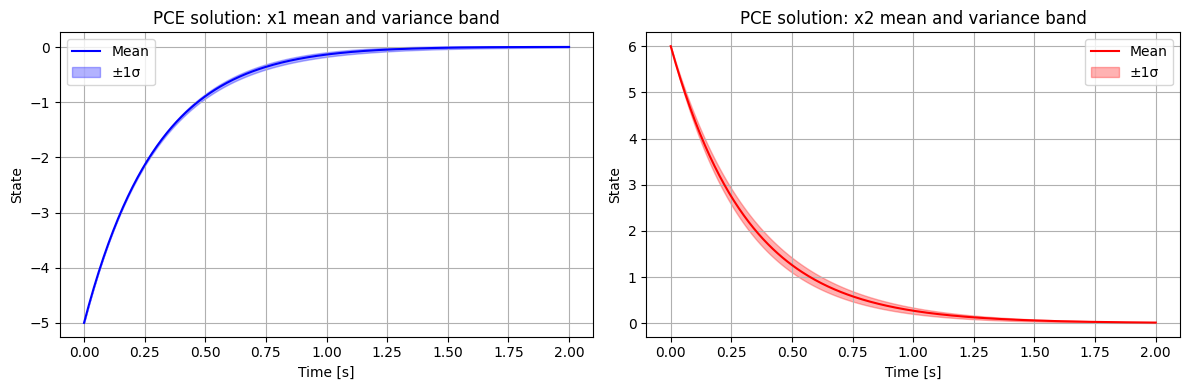

In [19]:
# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- x1 のプロット ---
axes[0].plot(sol.t, mean_x1, label="Mean", color="blue")
axes[0].fill_between(sol.t, mean_x1 - np.sqrt(var_x1), mean_x1 + np.sqrt(var_x1), 
                     alpha=0.3, color="blue", label="±1σ")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("State")
axes[0].grid(True)
axes[0].legend()
axes[0].set_title("PCE solution: x1 mean and variance band")

# --- x2 のプロット ---
axes[1].plot(sol.t, mean_x2, label="Mean", color="red")
axes[1].fill_between(sol.t, mean_x2 - np.sqrt(var_x2), mean_x2 + np.sqrt(var_x2), 
                     alpha=0.3, color="red", label="±1σ")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("State")
axes[1].grid(True)
axes[1].legend()
axes[1].set_title("PCE solution: x2 mean and variance band")

# 全体のレイアウト調整
plt.tight_layout()
plt.show()


In [20]:
'''
# モンテカルロで実装
eigs_mc, mean_mc, var_mc = controller.simulate_mc(1000, initial_list, t_span, t_eval)

# プロットの準備
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- x1 のプロット ---
axes[0].plot(t_eval, mean_mc[0], label="MC Mean", color="blue")
axes[0].fill_between(t_eval, mean_mc[0] - np.sqrt(var_mc[0]), mean_mc[0] + np.sqrt(var_mc[0]), 
                     alpha=0.3, color="blue", label="±1σ")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("State")
axes[0].grid(True)
axes[0].legend()
axes[0].set_title("MC solution: x1 mean and variance band")

# --- x2 のプロット ---
axes[1].plot(t_eval, mean_mc[1], label="Mean", color="green")
axes[1].fill_between(t_eval, mean_mc[1] - np.sqrt(var_mc[1]), mean_mc[1] + np.sqrt(var_mc[1]), 
                     alpha=0.3, color="green", label="±1σ")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("State")
axes[1].grid(True)
axes[1].legend()
axes[1].set_title("MC solution: x2 mean and variance band")

# 全体のレイアウト調整
plt.tight_layout()
plt.show()
'''

'\n# モンテカルロで実装\neigs_mc, mean_mc, var_mc = controller.simulate_mc(1000, initial_list, t_span, t_eval)\n\n# プロットの準備\nfig, axes = plt.subplots(1, 2, figsize=(12, 4))\n\n# --- x1 のプロット ---\naxes[0].plot(t_eval, mean_mc[0], label="MC Mean", color="blue")\naxes[0].fill_between(t_eval, mean_mc[0] - np.sqrt(var_mc[0]), mean_mc[0] + np.sqrt(var_mc[0]), \n                     alpha=0.3, color="blue", label="±1σ")\naxes[0].set_xlabel("Time [s]")\naxes[0].set_ylabel("State")\naxes[0].grid(True)\naxes[0].legend()\naxes[0].set_title("MC solution: x1 mean and variance band")\n\n# --- x2 のプロット ---\naxes[1].plot(t_eval, mean_mc[1], label="Mean", color="green")\naxes[1].fill_between(t_eval, mean_mc[1] - np.sqrt(var_mc[1]), mean_mc[1] + np.sqrt(var_mc[1]), \n                     alpha=0.3, color="green", label="±1σ")\naxes[1].set_xlabel("Time [s]")\naxes[1].set_ylabel("State")\naxes[1].grid(True)\naxes[1].legend()\naxes[1].set_title("MC solution: x2 mean and variance band")\n\n# 全体のレイアウト調整\nplt.tight_la

In [21]:
# # 6. グラフ描画
# plt.rcParams['font.family'] = 'Meiryo'
# plt.figure(figsize=(8, 4))
# plt.plot(sol.t, x_norms)
# plt.xlabel('Time [s]')
# plt.ylabel('||x(t)||')
# plt.title('状態ベクトル x(t) のノルムの時間変化')
# plt.grid(True)
# plt.tight_layout()
# plt.show()